**Dados de passageiros aéreos:**

In [94]:
import pandas as pd

path = 'https://raw.githubusercontent.com/cleyson02/time-series/main/AirPassengers.csv'

dados = pd.read_csv(path)

dados

,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121
...,...,...
139,1960-08,606
140,1960-09,508
141,1960-10,461
142,1960-11,390


In [95]:
dados.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Month        144 non-null    object
 1   #Passengers  144 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ KB


In [96]:
dados.duplicated().any()

False

In [125]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
from math import sqrt
from statsmodels.tsa.stattools import adfuller

path = 'https://raw.githubusercontent.com/cleyson02/time-series/main/AirPassengers.csv'
dados = pd.read_csv(path)

# Converter 'Month' para datetime e definir como índice
dados['Month'] = pd.to_datetime(dados['Month'])
dados.set_index('Month', inplace=True)

In [126]:
# Teste de estacionariedade usando o teste ADF (Augmented Dickey-Fuller)
def teste_estacionaria(dados):
    p_value = adfuller(dados)[1]
    print(p_value)
    if p_value < 0.05:
        print("A série é estacionária.")
    else:
        print("A série não é estacionária.")

# Chamada da função para realizar o teste de estacionariedade
teste_estacionaria(dados['#Passengers'])

0.991880243437641
A série não é estacionária.


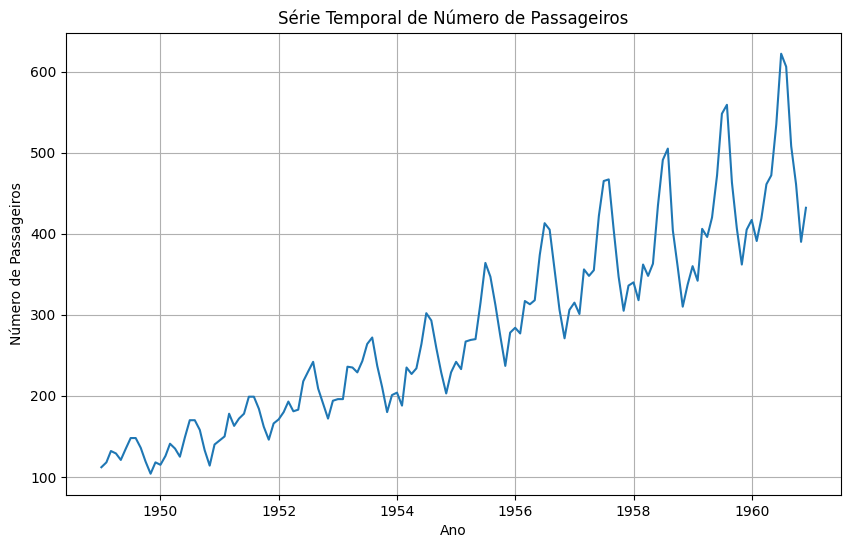

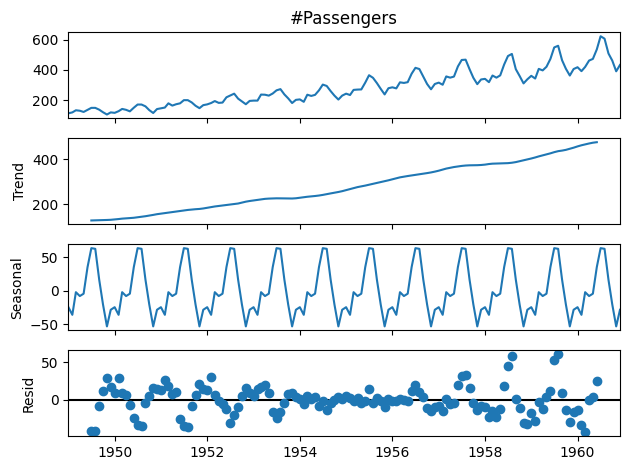

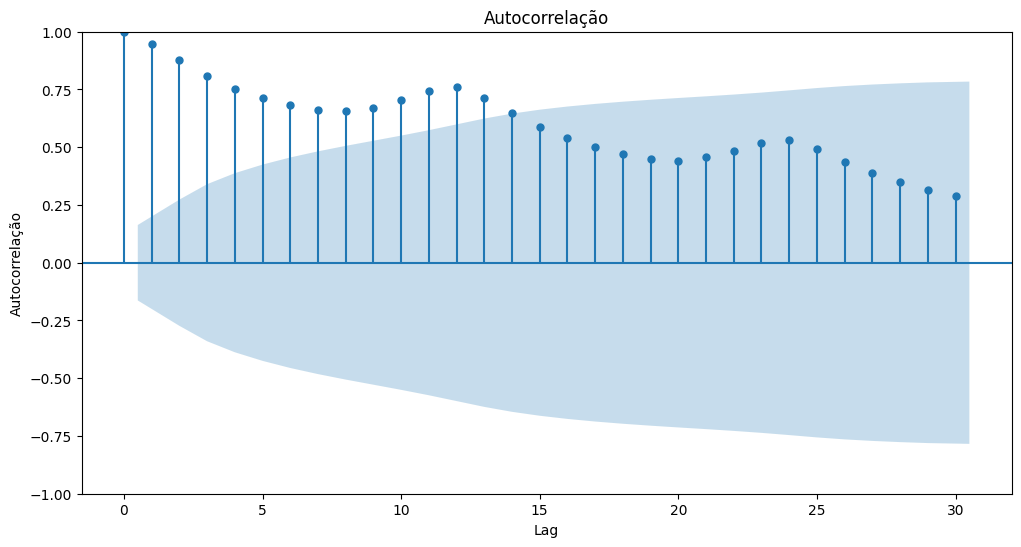

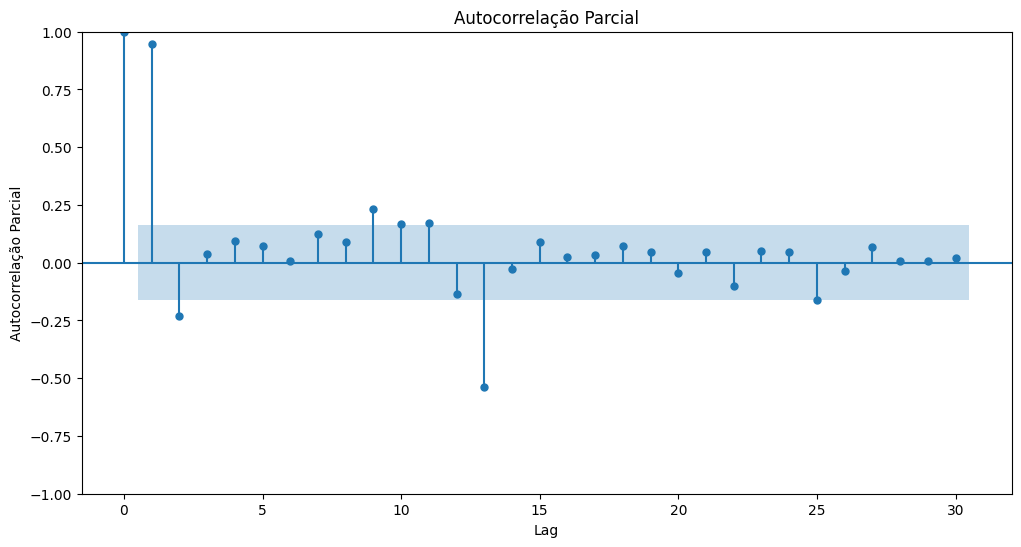

In [127]:
# Visualizar a série temporal
plt.figure(figsize=(10, 6))
plt.plot(dados['#Passengers'])
plt.title('Série Temporal de Número de Passageiros')
plt.xlabel('Ano')
plt.ylabel('Número de Passageiros')
plt.grid(True)
plt.show()

# Decomposição da série temporal para verificar tendência e sazonalidade
decomposicao = seasonal_decompose(dados['#Passengers'], model='additive')
decomposicao.plot()
plt.show()

# Autocorrelação e autocorrelação parcial
plt.figure(figsize=(12, 6))
plot_acf(dados['#Passengers'], lags=30, ax=plt.gca())
plt.xlabel('Lag')
plt.ylabel('Autocorrelação')
plt.title('Autocorrelação')
plt.show()

plt.figure(figsize=(12, 6))
plot_pacf(dados['#Passengers'], lags=30, ax=plt.gca())
plt.xlabel('Lag')
plt.ylabel('Autocorrelação Parcial')
plt.title('Autocorrelação Parcial')
plt.show()

In [128]:
# Diferenciar os dados
dados_diff = dados.diff().diff().dropna()

# Teste de estacionariedade após a diferenciação
teste_estacionaria(dados_diff['#Passengers'])

2.7328918500142026e-29
A série é estacionária.


In [129]:
# Definir conjunto de treinamento e teste
train_size = len(dados) - 12
train_final, test_final = dados.iloc[:train_size], dados.iloc[train_size:]

In [141]:
# Ajustar modelo SARIMAX com dados diferenciados
# order=(p, d, q)
# p = 0, 1, 2, 3
# d = 2
# q = 0, ..., 12
# seasonal_order=(P, D, Q, s)
# P = 1
# D = 1
# Q = 0, 1
# s = 12
modelo_final = SARIMAX(train_final, order=(3, 2, 1), seasonal_order=(1, 1, 1, 12))
resultado_final = modelo_final.fit()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [142]:
# Fazer previsões com dados diferenciados
previsoes_final = resultado_final.forecast(steps=len(test_final))

previsoes_final

1960-01-01    423.518253
1960-02-01    406.573495
1960-03-01    465.548763
1960-04-01    455.152199
1960-05-01    479.362324
1960-06-01    537.326690
1960-07-01    612.412914
1960-08-01    625.028983
1960-09-01    526.645082
1960-10-01    472.428108
1960-11-01    428.727627
1960-12-01    471.655273
Freq: MS, Name: predicted_mean, dtype: float64

In [143]:
# Calcular RMSE com dados diferenciados
rmse_final = sqrt(mean_squared_error(test_final['#Passengers'], previsoes_final))
print('RMSE:', rmse_final)

RMSE: 23.363518079768095


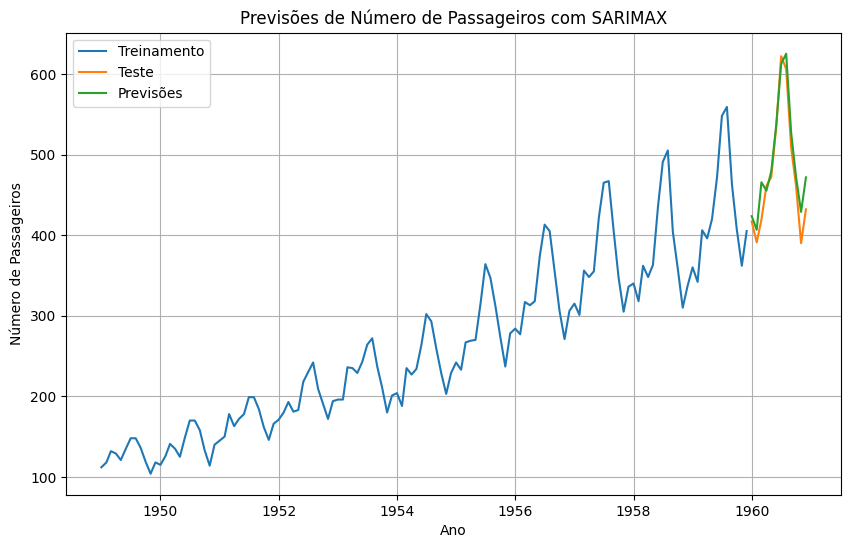

In [144]:
# Visualizar previsões com dados diferenciados
plt.figure(figsize=(10, 6))
plt.plot(train_final.index, train_final['#Passengers'], label='Treinamento')
plt.plot(test_final.index, test_final['#Passengers'], label='Teste')
plt.plot(test_final.index, previsoes_final, label='Previsões')
plt.title('Previsões de Número de Passageiros com SARIMAX')
plt.xlabel('Ano')
plt.ylabel('Número de Passageiros')
plt.legend()
plt.grid(True)
plt.show()

Anotação:

O gráfico de autocorrelação vai me mostrar a saúde da série temporal em relação ao passado, se a maioria dos pontos não estiverem na zona pintada, eu consigo prever o futuro daquela série, caso contrário, fico impossibilitado.

Tem tendência, tem sazonalidade.

Conjunto de Treinamento: O conjunto de treinamento foi definido como todos os dados, exceto os últimos 12 meses. Isso foi feito para garantir que o modelo seja treinado em dados históricos suficientes para capturar padrões e tendências sazonais.

Conjunto de Teste: O conjunto de teste foi definido como os últimos 12 meses dos dados. Essa escolha permite avaliar a capacidade do modelo em fazer previsões futuras com base nos dados históricos disponíveis.

Métrica de Avaliação: A métrica escolhida para avaliação do modelo foi o Root Mean Squared Error (RMSE). O RMSE ele é o desvio padrão da amostra da diferença do previsto e do realizado.

**Dados de vendas de álcool:**

In [105]:
import pandas as pd

path = 'https://raw.githubusercontent.com/cleyson02/Time-Series/main/Alcohol_Sales.csv'

dados = pd.read_csv(path)

dados

,DATE,S4248SM144NCEN
0,1992-01-01,3459
1,1992-02-01,3458
2,1992-03-01,4002
3,1992-04-01,4564
4,1992-05-01,4221
...,...,...
320,2018-09-01,12396
321,2018-10-01,13914
322,2018-11-01,14174
323,2018-12-01,15504


In [106]:
dados.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 325 entries, 0 to 324
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   DATE            325 non-null    object
 1   S4248SM144NCEN  325 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 5.2+ KB


In [107]:
dados.duplicated().any()

False

In [108]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
from math import sqrt
from statsmodels.tsa.stattools import adfuller

path = 'https://raw.githubusercontent.com/cleyson02/Time-Series/main/Alcohol_Sales.csv'
dados = pd.read_csv(path)

# Renomear as colunas
dados.columns = ['DATE', 'Sales']

# Converter 'DATE' para datetime e definir como índice
dados['DATE'] = pd.to_datetime(dados['DATE'])
dados.set_index('DATE', inplace=True)

In [109]:
# Teste de estacionariedade usando o teste ADF (Augmented Dickey-Fuller)
def teste_estacionaria(dados):
    p_value = adfuller(dados)[1]
    print(p_value)
    if p_value < 0.05:
        print("A série é estacionária.")
    else:
        print("A série não é estacionária.")

# Chamada da função para realizar o teste de estacionariedade
teste_estacionaria(dados['Sales'])

0.9987196267088919
A série não é estacionária.


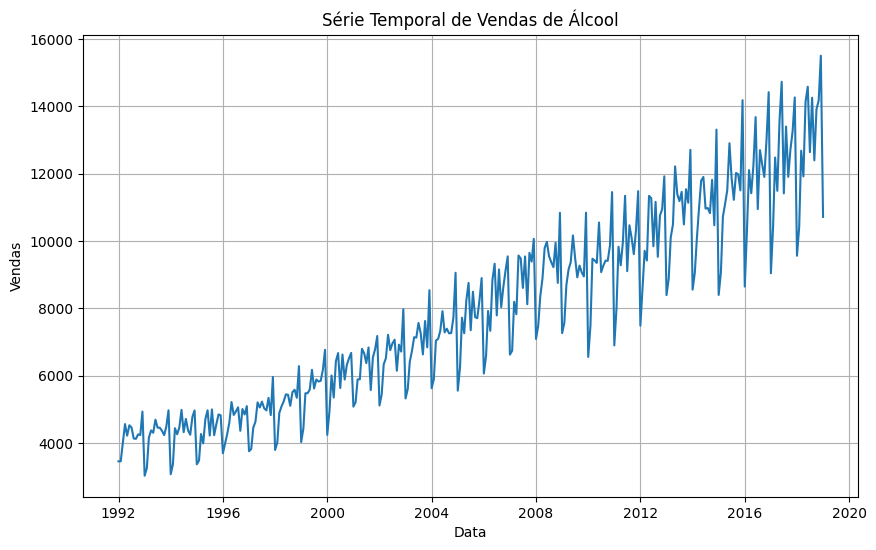

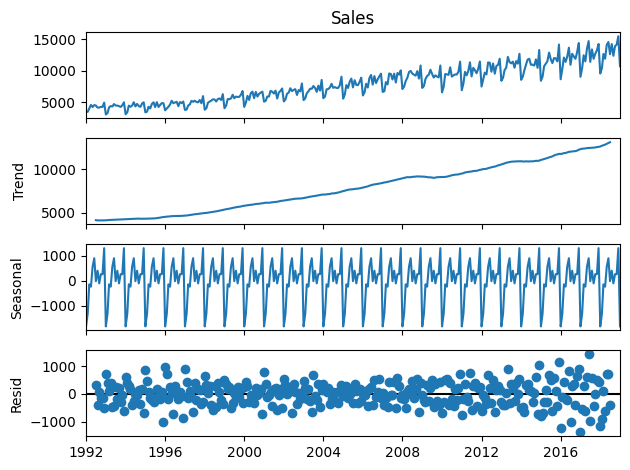

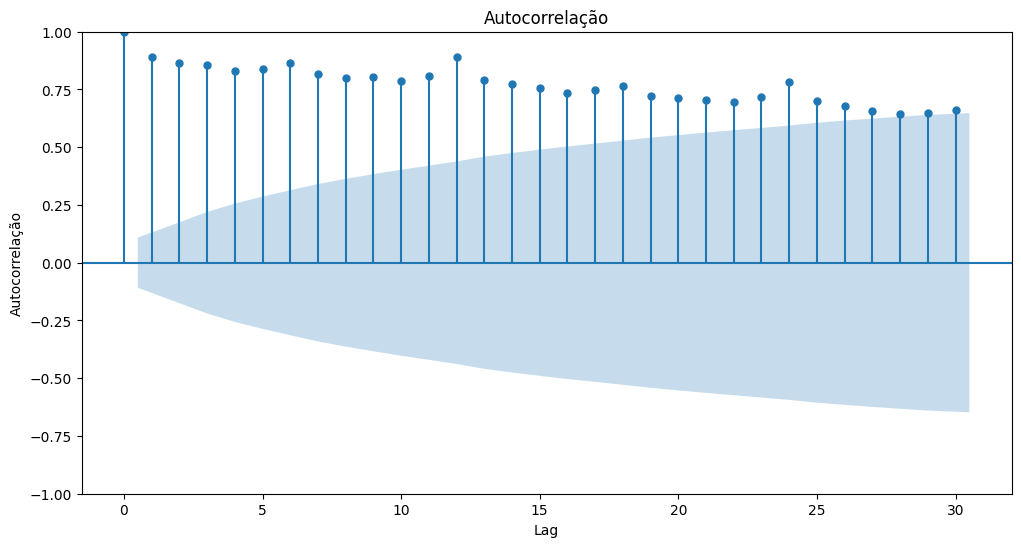

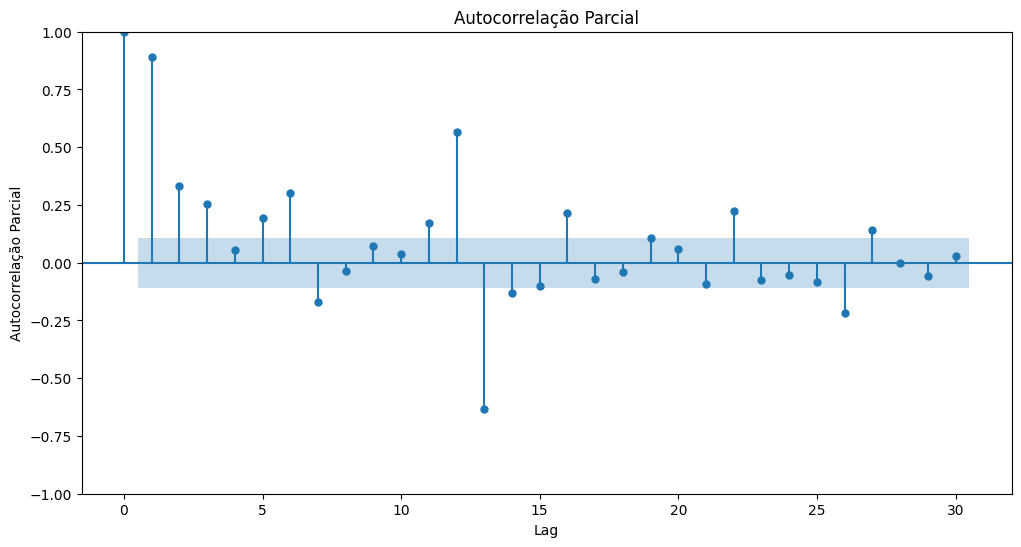

In [110]:
# Visualizar a série temporal
plt.figure(figsize=(10, 6))
plt.plot(dados['Sales'])
plt.title('Série Temporal de Vendas de Álcool')
plt.xlabel('Data')
plt.ylabel('Vendas')
plt.grid(True)
plt.show()

# Decomposição da série temporal para verificar tendência e sazonalidade
decomposicao = seasonal_decompose(dados['Sales'], model='additive')
decomposicao.plot()
plt.show()

# Autocorrelação e autocorrelação parcial
plt.figure(figsize=(12, 6))
plot_acf(dados['Sales'], lags=30, ax=plt.gca())
plt.xlabel('Lag')
plt.ylabel('Autocorrelação')
plt.title('Autocorrelação')
plt.show()

plt.figure(figsize=(12, 6))
plot_pacf(dados['Sales'], lags=30, ax=plt.gca())
plt.xlabel('Lag')
plt.ylabel('Autocorrelação Parcial')
plt.title('Autocorrelação Parcial')
plt.show()

In [111]:
# Diferenciar os dados
dados_diff = dados.diff().dropna()

# Teste de estacionariedade após a diferenciação
teste_estacionaria(dados_diff['Sales'])

0.0003408284921170342
A série é estacionária.


In [112]:
# Definir conjunto de treinamento e teste com dados diferenciados
train_size = len(dados) - 12
train_final, test_final = dados.iloc[:train_size], dados.iloc[train_size:]

In [113]:
# Ajustar modelo SARIMAX com dados diferenciados
# order=(p, d, q)
# p = 0, 1, 2, 3, 4
# d = 1
# q = 0, ..., 25
# seasonal_order=(P, D, Q, s)
# P = 1
# D = 1
# Q = 0, 1, 2
# s = 12
modelo_final = SARIMAX(train_final, order=(4, 1, 1), seasonal_order=(1, 1, 2, 12))
resultado_final = modelo_final.fit()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [114]:
# Fazer previsões com dados diferenciados
previsoes_final = resultado_final.forecast(steps=len(test_final))

previsoes_final

2018-02-01    10792.422585
2018-03-01    12422.479972
2018-04-01    12100.668838
2018-05-01    13751.873980
2018-06-01    14691.004752
2018-07-01    12286.888644
2018-08-01    13487.327107
2018-09-01    12467.169466
2018-10-01    13243.721003
2018-11-01    13379.666839
2018-12-01    14782.756228
2019-01-01    10094.981518
Freq: MS, Name: predicted_mean, dtype: float64

In [115]:
# Calcular RMSE com dados diferenciados
rmse_final = sqrt(mean_squared_error(test_final['Sales'], previsoes_final))
print('RMSE:', rmse_final)

RMSE: 509.47793425192754


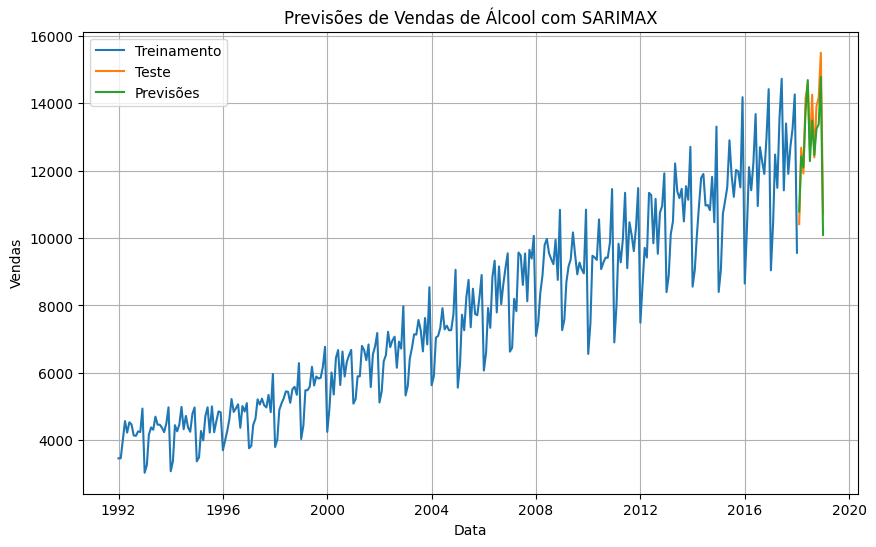

In [116]:
# Visualizar previsões com dados diferenciados
plt.figure(figsize=(10, 6))
plt.plot(train_final.index, train_final['Sales'], label='Treinamento')
plt.plot(test_final.index, test_final['Sales'], label='Teste')
plt.plot(test_final.index, previsoes_final, label='Previsões')
plt.title('Previsões de Vendas de Álcool com SARIMAX')
plt.xlabel('Data')
plt.ylabel('Vendas')
plt.legend()
plt.grid(True)
plt.show()